In [1]:
# imports

import os
import os.path as osp
import sys
from copy import deepcopy

import matplotlib.pyplot as plt

from mmengine.dataset import default_collate
from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS
from mmpretrain.structures import DataSample

import torch
import torchvision.transforms.functional as TF

from mmengine import Config

In [2]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [3]:
# baseline cfg
baseline_cfg = Config.fromfile('../configs/edl_mnist/default_lenet5_mnist.py')
baseline_ckpt = '../work_dirs/default_lenet5_mnist/epoch_30.pth'
assert osp.exists(baseline_ckpt)

# evidence deep learning cfg
edl_cfg = Config.fromfile('../configs/edl_mnist/edl_lenet5_mnist.py')
edl_ckpt = '../work_dirs/edl_lenet5_mnist/epoch_30.pth'
assert osp.exists(edl_ckpt)

First, we need to create a dataset with a single image and rotate it from 0 to 180 degrees. 

In [4]:
# avoid overwriting the original config
print(baseline_cfg.test_dataloader.dataset)
dataset_cfg: dict = deepcopy(baseline_cfg.test_dataloader.dataset)

# append '../' to the data_prefix
dataset_cfg['data_prefix'] = osp.join('../', dataset_cfg['data_prefix'])

dataset = DATASETS.build(dataset_cfg)
print(type(dataset))

{'type': 'MNIST', 'data_prefix': 'data/mnist', 'pipeline': [{'type': 'Resize', 'scale': 32}, {'type': 'PackInputs'}], 'test_mode': True}
04/22 03:42:37 - mmengine - WARNING - split="train" but test_mode=True. The training set will be used.


/home/ubuntu/.pyenv/versions/3.9.9/envs/uncert/lib/python3.9/site-packages/mmpretrain/datasets/mnist.py:216: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<class 'mmpretrain.datasets.mnist.MNIST'>


In [5]:
# the "1" examples is the 2nd sample in the test dataset
sample = dataset[2]
print(sample['data_samples'].gt_label)

tensor([1])


In [6]:
# Create DataSample of Rotated MNIST

def create_rotated_mnist_sample(sample: dict):
    img: torch.Tensor = sample['inputs']
    data_sample: DataSample = sample['data_samples']

    m = 180
    n = m // 10 + 1
    degs = torch.linspace(0, m, n)
    samples = []
    for deg in degs:
        img_rot = TF.rotate(img.clone(), float(deg), fill=0)
        ds = data_sample.clone()
        ds.set_field(deg, 'rotation', torch.Tensor)
        samples.append(
            dict(
                inputs=img_rot,
                data_samples=ds,
            )
        )

    return samples

samples = create_rotated_mnist_sample(sample)

We need to create a batch of all samples and perform inference on the loaded model.

In [7]:
def make_batch(data: list):
    return default_collate(data)

data = make_batch(samples)

In [8]:
# Load the model
edl_model = get_model(edl_cfg, pretrained=edl_ckpt)

Loads checkpoint by local backend from path: ../work_dirs/edl_lenet5_mnist/epoch_30.pth


In [12]:
# inference
edl_model.eval()
out = edl_model.test_step(data)

print(len(out))
print(out[0])

19
<DataSample(

META INFORMATION
    scale_factor: (1.1428571428571428, 1.1428571428571428)
    sample_idx: 2
    num_classes: 10
    img_shape: (32, 32)

DATA FIELDS
    pred_label: tensor([1])
    uncertainty: tensor([0.1042])
    rotation: 0.0
    gt_label: tensor([1])
    pred_score: tensor([0.0104, 0.9062, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104,
        0.0104])

) at 0x7f65f90edaf0>


In [25]:
uncertainty = torch.stack([o.uncertainty for o in out])
probs = torch.stack([o.pred_score for o in out])
imgs = torch.cat([s['inputs'] for s in samples], dim=-1).squeeze(0)
degs = torch.stack([o.rotation for o in out])

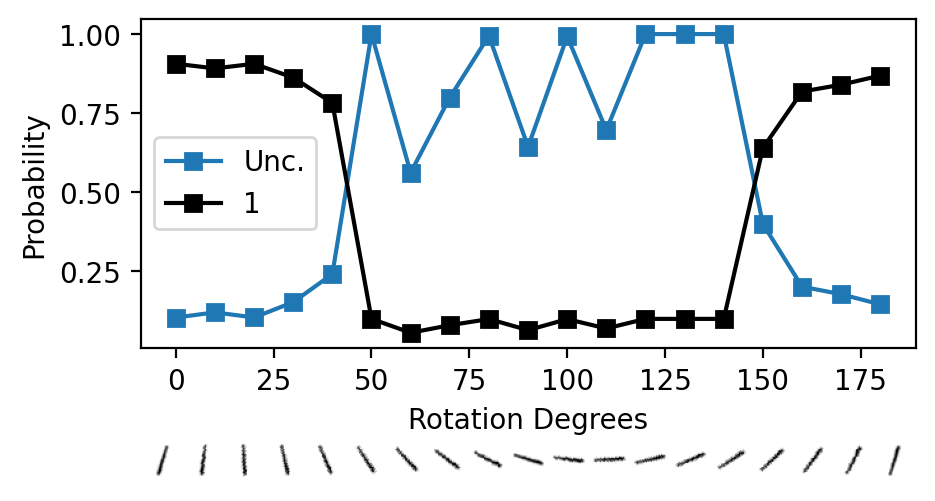

In [32]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [8, 1]}, figsize=(5, 3), dpi=200
)
fig.subplots_adjust(hspace=0.5)
ax1.plot(degs, uncertainty, label="Unc.", marker="s")
ax1.plot(degs, probs[:, 1], label="1", color="k", marker="s")
ax1.set_ylabel("Probability")
ax1.set_xlabel("Rotation Degrees")
ax1.legend()

ax2.imshow(255 - imgs, cmap="gray")
ax2.axis(False)

plt.show()